In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm
import pandas as pd

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.analysis import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global parameters

In [47]:
# global parameters
dt=1
epsilon=0.1
sigma=0.01
N=int(1e4)
mu=0.2
seed=1001

In [48]:
#mean field solution for T->inf
def a_inf(lam, mu, h):
    return mu*(1-np.exp(-h*dt))/(1-lam*(1-mu)-lam*mu*np.exp(-h*dt))

lam=0.0
print(lam, mu, a_inf(lam, mu, 0), a_inf(lam, mu, 1e3))

0.0 0.2 0.0 0.2


# Implementation of measures

### 1. Find smallest $h$ for which the overlap with the zero-input case is less than discrimination error $\varepsilon$
Note: $a(0)=0$ for all $\lambda$ and $\mu$ such that $P(o)=\mathcal{N}(0,\sigma)$

In [5]:
calc_overlap?

Signature: calc_overlap(pmf1, pmf2)
Docstring:
calculates the overlap between two discrete probability mass functions
ATTENTION: needs user to ensure that domains are identical!
File:      /data.nst/johannes/projects/sahel_finite-observation-dynamic-range/0_update/src/analysis.py
Type:      function

In [6]:
find_discriminable_inputs?

Signature:
find_discriminable_inputs(
    pmf,
    h_range,
    pmf_refs,
    epsilon: float,
    start='left',
    verbose=False,
)
Docstring:
Determine all inputs h in range h_range such that the overlap between all pmfs is less than epsilon
The pmfs of h_range[0] and h_range[1] sever as boundaries

# Parameter
- pmf: function
- h_range: array-like with length two
- epsilon: float
    discrimination error that specifies maximal overlap between two probability mass functions
File:      /data.nst/johannes/projects/sahel_finite-observation-dynamic-range/0_update/src/analysis.py
Type:      function

In [7]:
dynamic_range?

Signature: dynamic_range(h_range)
Docstring: Calculate the dynamic range from the range h_range
File:      /data.nst/johannes/projects/sahel_finite-observation-dynamic-range/0_update/src/analysis.py
Type:      function

[1.3152705591323866e-05, 2.7016106502754786e-05, 4.1649550785640885e-05, 5.711904427145929e-05, 7.349812453834629e-05, 9.08696195030545e-05, 0.00010932669546989648, 0.00012897399399719597, 0.0001499306907812005, 0.0001723324141183695, 0.00019633356127083716, 0.00022211188146187708, 0.0002498726254389868, 0.00027985333452363215, 0.00031233130129881576, 0.00034763245493126514, 0.0003861415396767748, 0.0004283162262325502, 0.0004747065201754203, 0.0005259779824483926, 0.0005829428013241289, 0.0006466056898101807, 0.0007182225372509726, 0.0007993816063792311, 0.0008921269045112833, 0.0009991313174147762, 0.001123955363254409, 0.00127145480466628, 0.0014484275776869867, 0.0016646869164144665, 0.0019349463147948754, 0.0022823207970617833, 0.002745309221791356, 0.003393142404071527, 0.0043641379302381544, 0.005980474083127359, 0.009205617319726946]
[0.01881407143322633, 0.009203729909484327, 0.005979627748355973, 0.0043636648456649415, 0.0033928405444843468, 0.002745098631712415, 0.0022821647

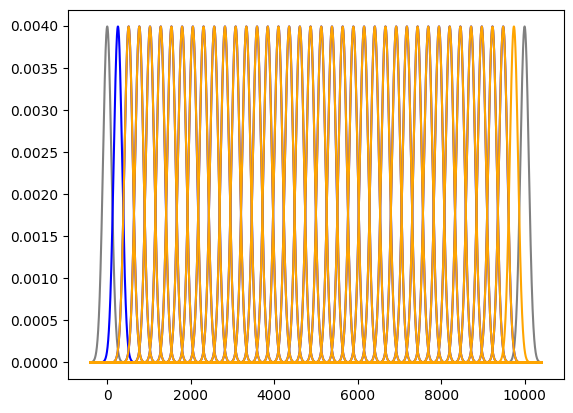

In [49]:
# test discriminable intervals
lam = 0.9999
Xs = np.arange(-4*sigma*N,N+4*sigma*N)

def pmf(h):
    # see below for formal derivation, here just as a test
    A = a_inf(lam, mu, h)*N
    # in domain with delta = 1
    delta = 1
    return stats.norm.pdf(Xs, A, sigma*N)*delta

h_range=[0,1e3]
pmf_ref_left = pmf(h_range[0])
pmf_ref_right = pmf(h_range[1])

plt.plot(Xs,pmf_ref_left, color="gray")
plt.plot(Xs,pmf_ref_right, color="gray")

hs_left = find_discriminable_inputs(pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print(hs_left)
for h in hs_left:
    plt.plot(Xs,pmf(h), color="blue")

hs_right = find_discriminable_inputs(pmf,h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print(hs_right)
for h in hs_right:
    plt.plot(Xs,pmf(h), color="orange")
#plt.legend()

# Consider network output with Gaussian noise
The output of the network is the sum of the network activity and Gaussian noise $\eta\sim\mathcal{N}(0,1)$ such that 
$$ o = a + \sigma\eta $$
The output is thus a convolution between $P(a)$ and $\mathcal{N}(0,\sigma)$.

For $T\to\infty$ the distribution of activity is a delta-distribution such that the the output distribution becomes a shifted Gaussian
$$ P(o) = \mathcal{N}(a(h|\lambda,\mu), \sigma)$$

# Analytic solution for $T\to\infty$
For the $T\to\infty$ case, we have a one-to-one mapping between input $h$ and network activity $a$, given by 
$$a(h|\lambda, \mu) = \frac{\mu\left(1-e^{-h\Delta t}\right)}{1-\lambda(1-\mu)-\lambda\mu e^{-h\Delta t}}$$

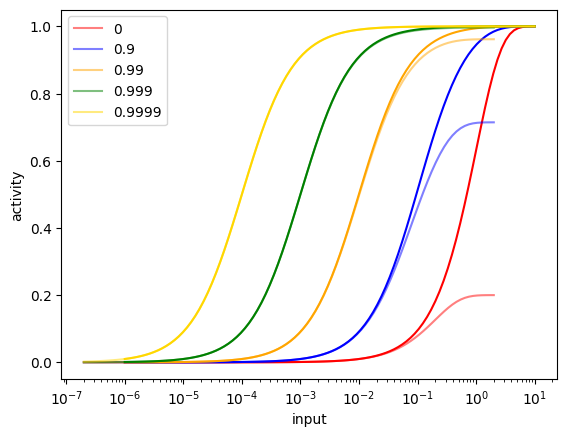

In [50]:
hs=np.logspace(-6,1,100)
colors=['red','blue','orange','green', 'gold']
for i,lam in enumerate([0,0.9,0.99,0.999, 0.9999]):
    plt.plot(hs*0.2, a_inf(lam, mu, hs), label='{}'.format(lam), color=colors[i], alpha=0.5)
    plt.plot(hs, a_inf(lam, 1.0, hs), color=colors[i])
plt.xscale("log")
plt.xlabel("input")
plt.ylabel("activity")
plt.legend()

100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


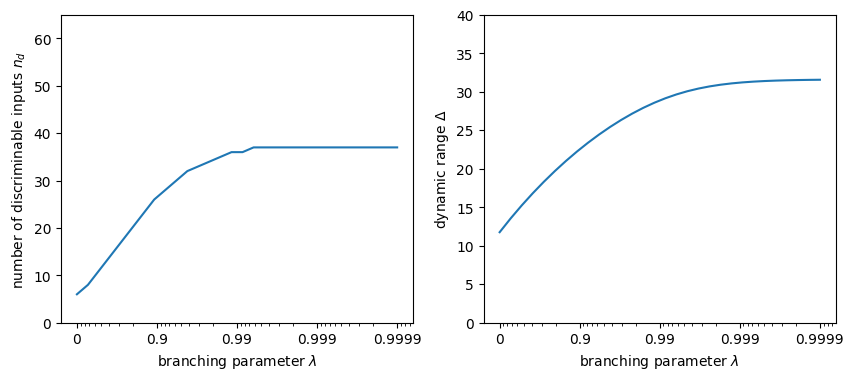

In [51]:
# network parameters
Xs = np.arange(-4 * sigma * N, N + 4 * sigma * N)
lams_inf = 1 - np.logspace(-4, 0, 30)

# analysis parameters
drs_inf = np.zeros(len(lams_inf))
nds_inf = np.zeros(len(lams_inf))
h_range = [0, 1e1]

for i, lam in tqdm(enumerate(lams_inf), total=len(lams_inf)):
    # distribution of noisy output
    def pmf_o_given_h(h):
        A = a_inf(lam, mu, h) * N
        return stats.norm.pdf(Xs, A, sigma * N)

    pmf_ref_left = pmf_o_given_h(h_range[0])
    pmf_ref_right = pmf_o_given_h(h_range[1])
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, verbose=False)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    drs_inf[i] = dynamic_range((hs_left[0], hs_right[0]))
    nds_inf[i] = 0.5 * (len(hs_left) + len(hs_right))

# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_inf, nds_inf)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_inf, drs_inf)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

# Analysis of data

In [52]:
# For ML part
import torch
from torch import nn
filename = f'./dat/simulation_approximation_seed={seed}.pkl'
sim_approx = FunctionApproximation(filename=filename)
print(sim_approx.params['N'])

10000


In [53]:
test = stats.norm(loc=0, scale=1)
print(test.ppf(0.25))
print(test.ppf(0.5))
print(test.ppf(0.75))

-0.6744897501960817
0.0
0.6744897501960817


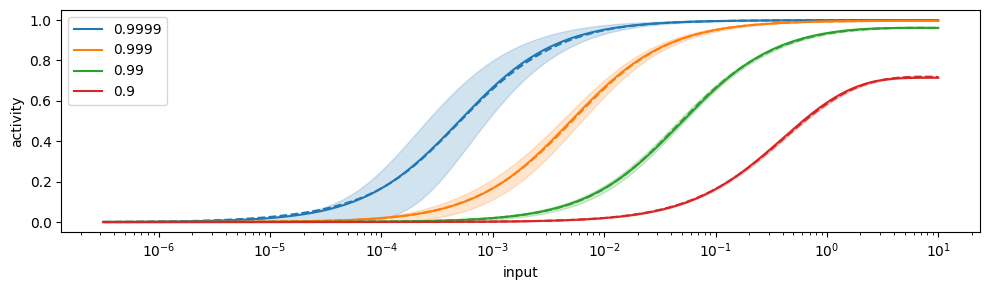

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3))
hs = 10**np.linspace(-6.5, 1, 200)
window=1
for i, lam in enumerate([0.9999, 0.999, 0.99, 0.9]):
    # theory
    ref = axes.plot(hs, a_inf(lam, mu, hs), label='{}'.format(lam))
    # simulation approximation with variance!
    avals, bvals = sim_approx(lam*np.ones_like(hs), window*np.ones_like(hs), hs)
    mean = avals/(avals+bvals)
    # calculate percentiles from stats.beta(a,b)
    beta = stats.beta(avals, bvals)
    percentile_25 = beta.ppf(0.25)
    percentile_50 = beta.ppf(0.5)
    percentile_75 = beta.ppf(0.75)
    axes.plot(hs, mean, color=ref[0].get_color(), linestyle='--')
    axes.fill_between(hs, percentile_25, percentile_75, color=ref[0].get_color(), alpha=0.2)
#axes.set_yscale("log")
axes.set_xscale("log")
axes.set_xlabel("input")
axes.set_ylabel("activity")
axes.legend()
plt.tight_layout()
plt.show()

### Convolution of beta distribution with Guassian 

In [55]:
N = sim_approx.params['N']
delta = 1/N
support = np.arange(0, 1+4*sigma, delta)
support = np.concatenate((-support[::-1], support[1:]))

# TODO: include loc and scale into params
loc = -0.0001	
scale = 1.0002

def ml_pmf(window, lam, h, verbose=False):
    a,b = sim_approx(lam, window, h)
    # pmf as difference of cdf to ensure that the pmf is normalized
    pmf_beta = np.diff(stats.beta.cdf(support, a, b, loc=loc, scale=scale))
    # convolution with a Gaussian distribution at every point of the support
    pmf_norm = stats.norm.pdf(support, 0, sigma)*delta
    return np.convolve(pmf_beta, pmf_norm, mode="same")

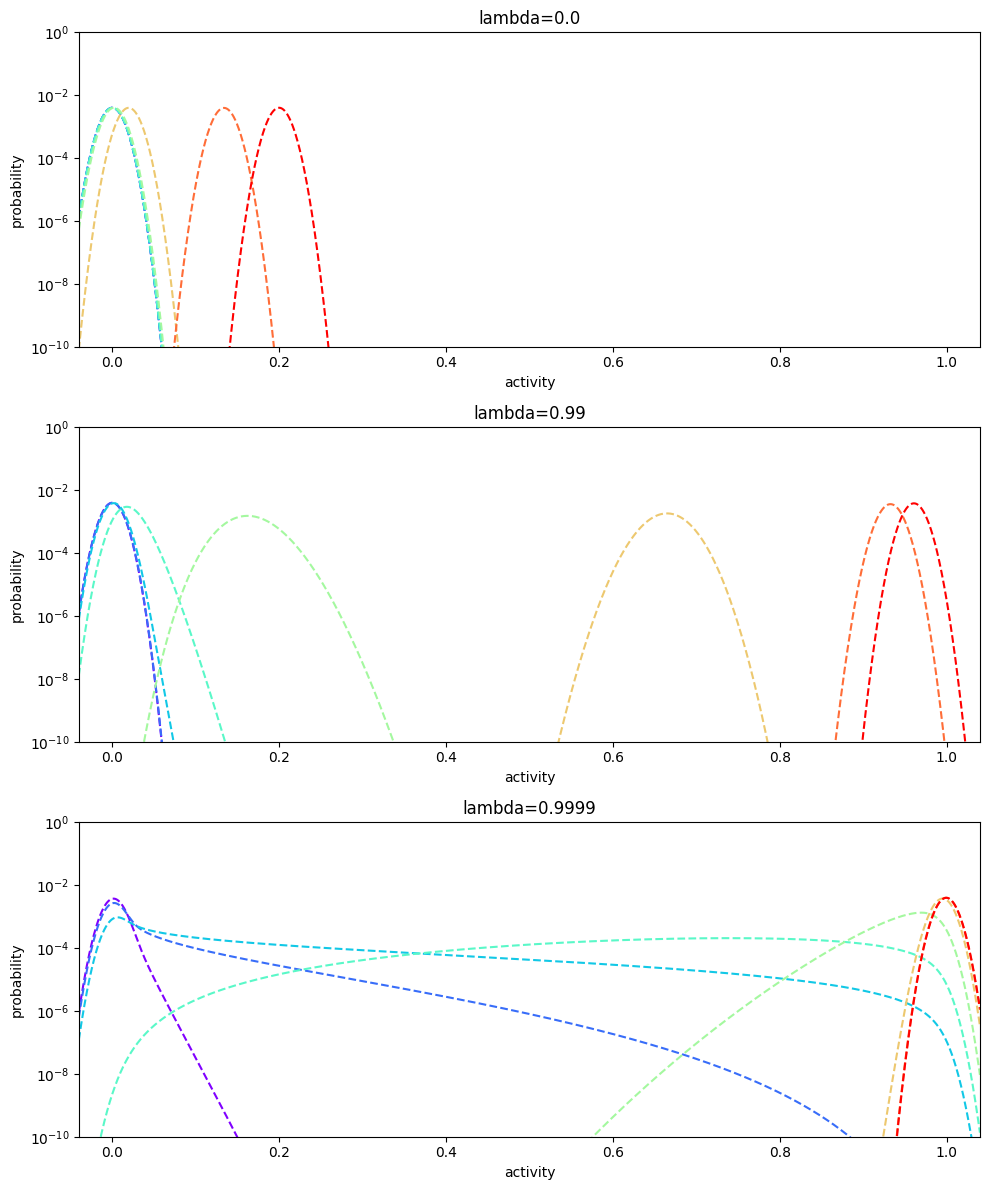

In [56]:
from matplotlib.pyplot import cm

# plot resulting distributions for different values of h and epsilon
list_lam = [0.0, 0.99, 0.9999]
fig, axes = plt.subplots(len(list_lam),1, figsize=(10, 4*len(list_lam)))

list_hs = 10**np.linspace(-6, 1, 8)
for (i,lam) in enumerate(list_lam):
    color = iter(cm.rainbow(np.linspace(0, 1, len(list_hs))))
    for h in list_hs:
        c = next(color)
        # from ML dashed
        pmf_ml = ml_pmf(window, lam, h)
        axes[i].plot(support, pmf_ml, color=c, linestyle='--')
        axes[i].set_xlim(0-4*sigma,1+4*sigma)
        axes[i].set_xlabel("activity")
        axes[i].set_ylabel("probability")
        axes[i].set_title("lambda={}".format(lam))
        axes[i].set_yscale("log")
        axes[i].set_ylim(1e-10, 1e0)
plt.tight_layout()


From the interpolation model we can obtain estimates of the dynamic range and the resolution

Important: Need to be able to specify reference distributions! Else we cannot parse no/full activity for simulations. Reference could come from infinite-T solution plus Gaussian!

0.0
hs_left:  [0.1323512989230912, 0.27845940744987974, 0.4473609720528709, 0.6564086914935261, 0.9370948606043044, 1.3655744452527596]
hs_right:  [1.9272217221554335, 1.2320579060344925, 0.8547079581041453, 0.5970923817248918, 0.400633383526061, 0.23899600011564212]


(-0.04, 1.04)

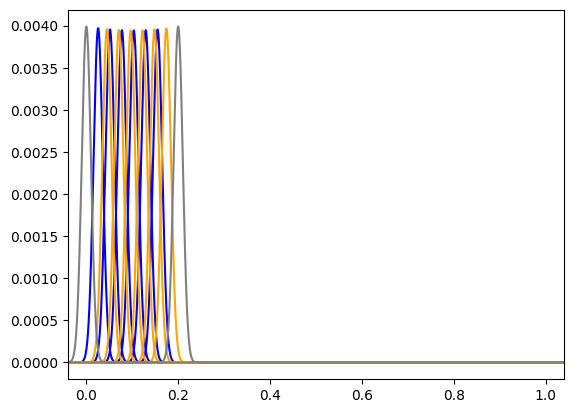

In [43]:
# test discriminable intervals
lam = 0.0
window = 1 
def _pmf(h):
    return ml_pmf(window, lam, h)

# has to be in range of data! 
h_range=[10**-7,10]
# pmf from Gaussians around mean-field solution for h=0 and h->infty
# support defined above and needs to be consistent with the ml_pmf function!
print(a_inf(lam, mu, 0))
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta

hs_left = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left")
print("hs_left: ", hs_left)
for h in hs_left:
    plt.plot(support, _pmf(h), color="blue")

hs_right = find_discriminable_inputs(_pmf, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
print("hs_right: ", hs_right)
for h in hs_right:
    plt.plot(support, _pmf(h), color="orange")

plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)

# plt.legend()

In [58]:
lams = 1 - 10**np.linspace(0,-4, 20)
print(lams)

# analysis parameters
drs = np.zeros(len(lams))
nds = np.zeros(len(lams))
mis = np.zeros(len(lams))

# need to exclude the zero here because of logh fit
h_range=[10**-6.5, 10]

for i, lam in tqdm(enumerate(lams), total=len(lams)):
    print(i,lam)
    # distribution is given by Beta-distribution specified by a and b
    def pmf_o_given_h(h):
        return ml_pmf(window, lam, h)
    pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
    pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
    hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon)
    hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right")
    # print(hs_left,hs_right)
    if len(hs_left) > 0 and len(hs_right) > 0:
        drs[i] = dynamic_range((hs_left[0], hs_right[0]))
        nds[i] = 0.5 * (len(hs_left) + len(hs_right))
    else:
        drs[i] = 0
        nds[i] = 0


[-9.00000000e+00 -5.16101529e+00 -3.20291623e+00 -2.10733633e+00
 -1.44802314e+00 -1.02781842e+00 -7.47616763e-01 -5.53989921e-01
 -4.16372569e-01 -3.16369054e-01 -2.42415456e-01 -1.86965320e-01
 -1.44933231e-01 -1.12796852e-01 -8.80589167e-02 -6.89137440e-02
 -5.40340449e-02 -4.24307591e-02 -3.33585251e-02 -2.62504388e-02
 -2.06720874e-02 -1.62885632e-02 -1.28404099e-02 -1.01258364e-02
 -7.98740905e-03 -6.30199429e-03 -4.97309419e-03 -3.92496532e-03
 -3.09808044e-03 -2.44561017e-03 -1.93068542e-03 -1.52426083e-03
 -1.20344321e-03 -9.50181459e-04 -7.50238009e-04 -5.92380428e-04
 -4.67745423e-04 -3.69338076e-04 -2.91637329e-04 -2.30285021e-04]


  0%|          | 0/40 [00:00<?, ?it/s]

0 -9.0


  0%|          | 0/40 [00:00<?, ?it/s]


AssertionError: 

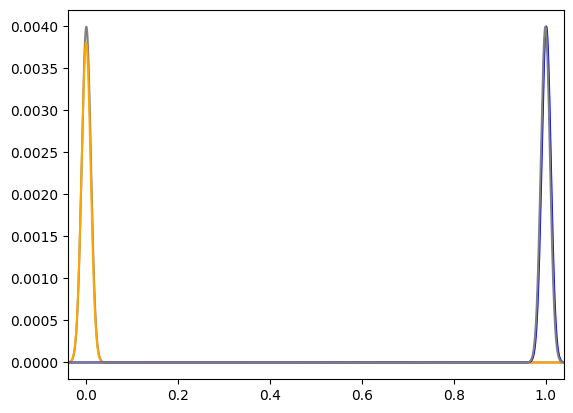

hs from left
possible solution: h=0.00014642244268902262 with overlap to end of 0.00036131173848048966 ... accepted
possible solution: h=0.0014391328045296468 with overlap to end of 0.009653638781501717 ... accepted
possible solution: h=0.010411023009432 with overlap to end of 0.11969698048953048 ... rejected
hs from right
possible solution: h=0.00872620972947351 with overlap to end of 1.677185009280933e-32 ... accepted
possible solution: h=0.0012114569363611786 with overlap to end of 2.977564726885441e-06 ... accepted
possible solution: h=0.00011427100958522482 with overlap to end of 0.12901152231231267 ... rejected
[0.00014642244268902262, 0.0014391328045296468]


In [24]:
# check large lambda in more detail why there is no discriminable points when coming from left
lam = 0.0
window=1
def pmf_o_given_h(h):
    return ml_pmf(window, lam, h)
h_range=[10**-7, 10]
pmf_ref_left = stats.norm.pdf(support, a_inf(lam, mu, 0), sigma)*delta
pmf_ref_right = stats.norm.pdf(support, a_inf(lam, mu, 1e3), sigma)*delta
plt.plot(support, pmf_ref_left, color="gray")
plt.plot(support, pmf_o_given_h(h_range[0]), color="orange")
plt.plot(support, pmf_o_given_h(h_range[-1]), color="blue")
plt.plot(support, pmf_ref_right, color="gray")
plt.xlim(0-4*sigma,1+4*sigma)
plt.show()

print("hs from left")
hs_left = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="left", verbose=True)
print("hs from right")
hs_right = find_discriminable_inputs(pmf_o_given_h, h_range, [pmf_ref_left, pmf_ref_right], epsilon, start="right", verbose=True)
print(hs_left)

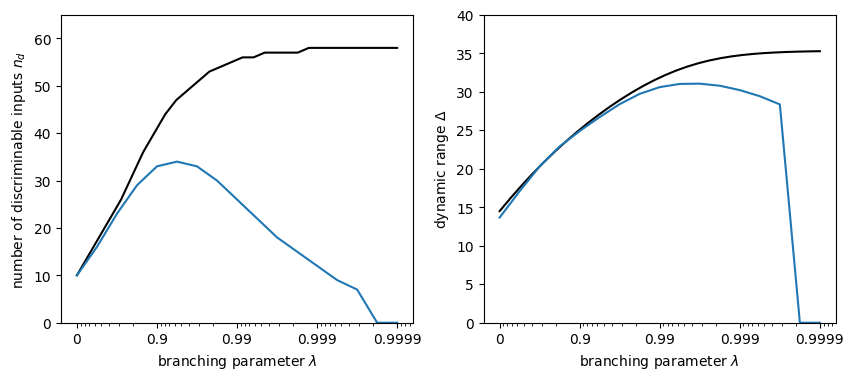

In [104]:
# plot the number of discriminable inputs for different values of epsilon and T in a main plot with an inset
markers = ["o", "s", "^", "P", "d"]
legends = ["$1$ ms", "$10$ ms", "$10^2$ ms", "$10^3$ ms", "$10^4$ ms"]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(1 - lams_mf, nds_inf, label="inf", color="black")
ax[0].plot(1 - lams, nds)
ax[0].set_xlabel("branching parameter $\lambda$")
ax[0].set_ylim(0, 65)
ax[0].set_ylabel("number of discriminable inputs $n_d$")
ax[0].set_xscale("log")
ax[0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[0].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[0].invert_xaxis()
ax[1].plot(1 - lams_mf, drs_inf, label="inf", color="black")
ax[1].plot(1 - lams, drs)
ax[1].set_xlabel("branching parameter $\lambda$")
ax[1].set_ylim(0, 40)
ax[1].set_ylabel("dynamic range $\Delta$")
ax[1].set_xscale("log")
ax[1].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
ax[1].set_xticklabels(["0.9999", "0.999", "0.99", "0.9", "0"])
ax[1].invert_xaxis()

## TODO:
- Develop an approximation to the finite-time solution as a correction to the infinite T limit?
- Fit this?
- Or take absolute maximum? -> as inset?
- Only Fig n_d and DR ... Lets try to replot with development of maxima as inset
